# 梯度下降法

藉由最小化成本函數(誤差函數)的最佳化演算法。

# 梯度下降法 Adaline 
<img src="image/logistic.png" width="700">  
這邊直接用後面邏輯式迴歸的概念圖

* 運作原理:   

#批次(batch)
  1. 初始化隨機符合常態很小的權重  
  2. Net input function:樣本x與權重w內積再加上權重的常數項(偏誤單元)  
  3. 流經activate function(使感知器變成非線性)
  4. Threshold function:將Net input 將壓縮(預測)成0和1  
  5. 計算預測值和實際值的誤差(成本函數) #梯度下降法核心 
  6. Weight update:誤差和學習速率相乘並加回原本的權重以及偏誤單元  

In [2]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float 學習速率
    n_iter : int 迭代次數
    random_state : int 隨機種子

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list 成本函數

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
           #activation沒有任何影響,只是為了說明資訊如何經過啟動層
           #和perceptron不同,這裡是考慮整個樣本來計算梯度(batch)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [3]:
import pandas as pd
df = pd.read_csv('data/iris.csv')


# 學習速率 eta

調整每次更新權重時成本函數(梯度)的係數:  
太低,能逐步收斂至局部最小值,但是需要更新的次數就會增多,增加計算時間.  
太高,容易衝過全域最小值,演算法不容易尋找到最小值並且容易發散.

## 比較不同學習速率的梯度下降法

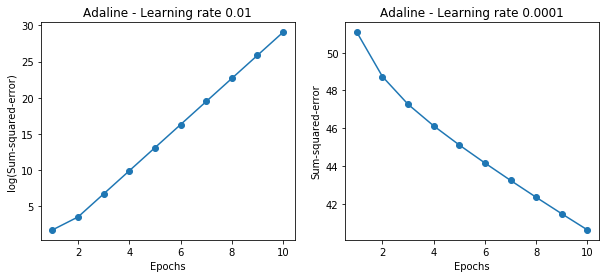

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv('data/iris.csv')
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0, 2]].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1),np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

### 特徵縮放  

* EX: 標準化

能幫助梯度下降法更快的收斂

In [6]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

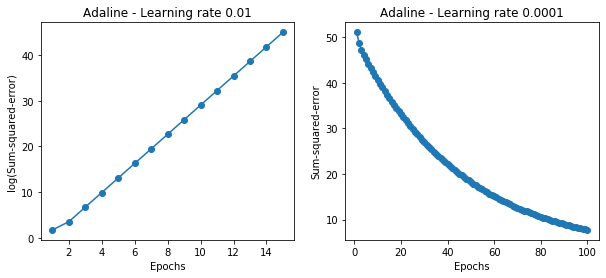

In [7]:

fig,ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.01).fit(X, y)
ax2[0].plot(range(1, len(ada1.cost_) + 1),np.log10(ada1.cost_), marker='o')
ax2[0].set_xlabel('Epochs')
ax2[0].set_ylabel('log(Sum-squared-error)')
ax2[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=100, eta=0.0001).fit(X, y)
ax2[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax2[1].set_xlabel('Epochs')
ax2[1].set_ylabel('Sum-squared-error')
ax2[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

## 隨機梯度下降 (stochastic gradient descent)

#逐筆更新(它會每個訓練樣本以遞增的方式來更新加權)  
* 每輪處理都得將數據位置攪亂以避免出現週期(shuffle)
* 通常能更快的向全域最小值收斂
* 方便進行線上學習(partial_fit):  
  當有新數據時可以即時訓練模型,訓練數據可以再更新完權重後丟棄


In [8]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
    n_iter : int
    shuffle : bool (default: True) 數據在處理前是否要先攪亂位置(防止數據週期性的出現)
    random_state : int
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        #初始化權重
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            #逐筆更新權重
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            #每輪平均成本
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
       #不初始化權重
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """攪亂資料"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

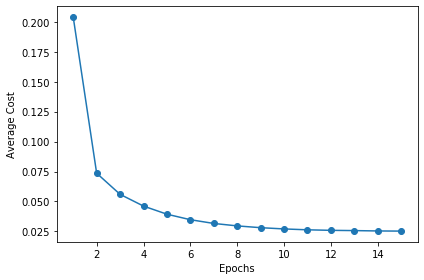

In [9]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y) #用標準化後資料



plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('images/02_15_2.png', dpi=300)
plt.show()

如果數據要以線上串流方式修改模型,對個別樣本呼叫partial_fit就可以了.